In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import sys
import tempfile
import pyabc

import healpy as hp
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
import pandas as pd

sys.path.insert(0, '/home/aew492/lss-dipoles/code')
import tools
import dipole
import generate_mocks as gm
import multipoles
from abc_for_qso import get_catalog_info

### helper functions

In [3]:
def get_fake_data(case_dir):
    
    # load fake data info: get the data map and convert to overdensity
    fake_data = np.load(os.path.join(case_dir, 'fake_data.npy'), allow_pickle=True).item()
    qmap = fake_data['data']['data'].astype(float)
    Nunmasked = np.sum(qmap != 0.)
    qmap[qmap == 0.] = np.nan
    
    # selfunc-corrected
    qmap_corr = qmap / fake_data['selfunc']
    
    # overdensity
    odmap = qmap / np.nanmean(qmap) - 1
    odmap_corr = qmap_corr / np.nanmean(qmap_corr) - 1
    
    # back out the dipole 3-vector from the input amplitude and CMB dipole direction
    input_kin_dipole_comps = dipole.cmb_dipole(amplitude=fake_data['input_dipole_amp'], return_comps=True)
    
    # construct the kinematic dipole and excess power maps
    input_kin_dipmap = dipole.dipole_map(np.append(0, input_kin_dipole_comps))
    try:
        excess_map = hp.sphtfunc.alm2map(fake_data['alms'], 64)
    except TypeError:  # this happens if there is zero excess power, then the alms are zero
        assert np.all(fake_data['alms'] == 0.)
        excess_map = np.zeros_like(input_kin_dipmap)
    total_map = input_kin_dipmap + excess_map
    
    # dipole in the map: fit the dipole using healpy's least-squares fit function
    #  we trust this to give us the true dipole since we're working on the full sky
    fit_dipole_comps = hp.fit_dipole(total_map)[1]
    print(f"best-fit dipole (no SN):\t{fit_dipole_comps}\tamplitude = {np.linalg.norm(fit_dipole_comps):.4f}")
    
    # projection of the total dipole onto the CMB dipole direction
    proj = (np.dot(input_kin_dipole_comps, fit_dipole_comps)/np.linalg.norm(input_kin_dipole_comps)**2)*input_kin_dipole_comps
    true_dipamp_proj = np.linalg.norm(proj)
    print(f"amplitude of the total dipole projected onto the expected dipole direction:\t{true_dipamp_proj:.5f}")

    return dict(odmap=odmap, odmap_corr=odmap_corr,
                input_kin_dipmap=input_kin_dipmap, excess_map=excess_map, total_map=total_map,
                true_dipamp_proj=true_dipamp_proj, Nunmasked=Nunmasked, fit_dipole_comps=fit_dipole_comps, selfunc=fake_data['selfunc'],
               fake_data_dict=fake_data)

In [5]:
def get_abc_results_dipole_excess(fn, xticks=None, title=None, plot=True):

    res = np.load(fn, allow_pickle=True).item()
    history = res['history']
    prior = res['prior']
    posterior = res['posterior']
    selfunc = res['selfunc']
    expected_dipamp = res['expected_dipole_amp']
    print(f"expected dipole_amp = {expected_dipamp}")
    
    # quantiles
    df, w = posterior
    q_dipamp = tools.quantile(df['dipole_amp'], [0.16, 0.5, 0.84], weights=w)
    q_excess = tools.quantile(df['log_excess'], [0.16, 0.5, 0.84], weights=w)

    # calculate the sigma discrepancy: ****check with Kate and Hogg: is this the right way to do this?
    # z score is z = (x_0 - \mu) / \sigma , where x_0 is the null hypothesis, \mu is mean (or MAP? or median?)
    #    and \sigma = std. of the posterior
    
    # how different is the mean from the median?
    print(f"mean dipole_amp = {pyabc.weighted_statistics.weighted_mean(df['dipole_amp'], w):.4f}")
    print(f"median dipole_amp = {q_dipamp[1]:.4f}")
    mu = q_dipamp[1]
    
    # standard deviation
    sigma = pyabc.weighted_statistics.weighted_std(df['dipole_amp'], w)
    print(f"std dipole_amp = {sigma:.4f}")

    relamp = np.array(q_dipamp) / expected_dipamp
    
    # z score
    z = (expected_dipamp - mu) / sigma
    print(f"z score = {z:.4f}")

    if plot:
        # plot (copied and adjusted from the pyabc.visualization source code)
        fig, axs = plt.subplots(2, 2, figsize=(7,6), tight_layout=True)
        
        df, w = posterior
    
        par_ids = [x for x in prior.keys()]
        labels = [r'$|\vec{\mathcal{D}}_{\mathrm{proj},k}|$', r'$\log \bar C$']  # bug: these labels are hard-coded
    
        for i, par_id in enumerate(par_ids):
        
            # quantiles?
            q = tools.quantile(df[par_id], [0.16, 0.5, 0.84], weights=w)
            
            # diagonal
            ax = axs[i, i]
            ax.axvline(q[1], c='k', alpha=0.4, ls='-', label='Median')
            ax.axvspan(q[0], q[2], color='k', alpha=0.05)
            ax.axhline(0., c='k', alpha=0.5, lw=0.5)
            if i == 0:
                ax.axvline(expected_dipamp, c='crimson', alpha=0.8, lw=1.5, label='Expected')
                ax.legend()
            ax.grid(alpha=0.5, lw=0.5)
            ax.set_xlim(prior[par_id].args[0], prior[par_id].args[0] + prior[par_id].args[1])
            if xticks is not None:
                ax.set_xticks(xticks)
            ax.axvline(0., c='k', alpha=0.5, lw=0.5)
            
            x, pdf = tools.get_kde_1d([df, w], prior, par_id)
            ax.plot(x, pdf, c='k', alpha=0.9, lw=1.5)
    
            axs[i,0].set_ylabel(labels[i], fontsize=12)
            axs[len(par_ids)-1,i].set_xlabel(labels[i], fontsize=12)
    
            for j in range(0, i):
        
                # lower
                ax = axs[i, j]
                x, y, pdf = tools.get_kde_2d([df, w], prior, par_ids[j], par_id)
                mesh = ax.pcolormesh(x, y, pdf, shading='auto', cmap='binary')
        
                # upper
                ax = axs[j, i]
                tools.scatter([df, w], prior, par_id, par_ids[j], ax, color='k', alpha=0.5, marker='.', s=3)
                ax.grid(alpha=0.5, lw=0.5)
        
        if title is not None:
            fig.suptitle(title)
    
        return q_dipamp, q_excess, relamp, z, res, axs
        
    else:
        return q_dipamp, q_excess, relamp, z, res

In [20]:
def get_abc_results_free_dipole_excess(fn, xticks=None, title=None, plot=True):

    res = np.load(fn, allow_pickle=True).item()
    history = res['history']
    prior = res['prior']
    posterior = res['posterior']
    selfunc = res['selfunc']
    expected_dipamp = res['expected_dipole_amp']

    par_ids = [x for x in prior.keys()]

    df, w = posterior

    # quantiles
    qs = [
        tools.quantile(df[par_id], [0.16, 0.5, 0.84], weights=w) for par_id in ['dipole_x', 'dipole_y', 'dipole_z', 'log_excess']
    ]

    if plot:

        fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(14,12), tight_layout=True)
        labels = [r'$\mathcal{D}_x$', r'$\mathcal{D}_y$', r'$\mathcal{D}_z$', r'$\log \bar C$']  # bug: these labels are hard-coded

        for i, par_id in enumerate(par_ids):
    
            # quantile
            q = qs[i]
            
            # diagonal
            ax = axs[i, i]
            ax.axvline(q[1], c='k', alpha=0.6, ls='-', label='Median')
            ax.axvspan(q[0], q[2], color='k', alpha=0.05)
            ax.axhline(0., c='k', alpha=0.5, lw=0.5)
            ax.grid(alpha=0.5, lw=0.5)
            ax.set_xlim(prior[par_id].args[0], prior[par_id].args[0] + prior[par_id].args[1])
            if xticks is not None:
                ax.set_xticks(xticks)
            ax.axvline(0., c='k', alpha=0.5, lw=0.5)
            
            x, pdf = tools.get_kde_1d([df, w], prior, par_id)
            ax.plot(x, pdf, c='k', alpha=0.9, lw=1.5)
    
            axs[i,0].set_ylabel(labels[i], fontsize=12)
            axs[len(par_ids)-1,i].set_xlabel(labels[i], fontsize=12)
    
            for j in range(0, i):
        
                # lower
                ax = axs[i, j]
                x, y, pdf = tools.get_kde_2d([df, w], prior, par_ids[j], par_id)
                mesh = ax.pcolormesh(x, y, pdf, shading='auto', cmap='binary')
        
                # upper
                ax = axs[j, i]
                tools.scatter([df, w], prior, par_id, par_ids[j], ax, color='k', alpha=0.5, marker='.', s=3)
                ax.grid(alpha=0.5, lw=0.5)
            
        if title is not None:
            fig.suptitle(title)

        return qs, res, axs

    else:
        return qs, res

In [7]:
def plot_posterior_evolution(res=None, history=None, param='log_excess', true_dipamp_proj=None, input_log_excess=None, shotnoise=None):
    assert param.lower() in ['dipole_amp', 'log_excess'], "param must be 'dipole_amp' or 'log_excess'"
    history = history if history is not None else res['history']
    fig, ax = plt.subplots(figsize=(7,4), tight_layout=True)
    norm = mpl.colors.Normalize(vmin=0, vmax=history.max_t)
    smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo_r')
    for i in range(history.max_t + 1):
        pyabc.visualization.plot_kde_1d_highlevel(history, param, t=i, ax=ax, color=smap.to_rgba(i), alpha=0.9)
    ax.grid(alpha=0.5, lw=0.5)
    ax.set_xlabel(param)
    ax.axhline(0., c='k', alpha=0.5, lw=0.5)
    fig.colorbar(smap, ax=ax, label='Generation')
    if res is not None:
        ax.set_xlim(res['prior'][param].args[0], res['prior'][param].args[0] + res['prior'][param].args[1])
    if param == 'log_excess':
        if input_log_excess is not None:
            ax.axvline(float(log_excess), c='royalblue', alpha=0.8, label='Input')
        if shotnoise is not None:
            ax.axvline(np.log10(shotnoise), c='mediumseagreen', alpha=0.8, ls='-', label='Shot noise')
    else:
        if true_dipamp_proj is not None:
            ax.axvline(true_dipamp_proj, c='royalblue', alpha=0.8, label='Truth')
    ax.legend()

## fake Quaia G20.0, 1x expected dipole, log excess power = -4 (max $\ell=2$)

I'm going to try to organize this in terms of increasing complexity: start with the ideal case where we can recover the input excess power, then see where things begin to break down.

In [9]:
# parameters to load results
nside = 2
base_rate_quaia = get_catalog_info('quaia_G20.0')['base_rate']
resdir = '/scratch/aew492/lss-dipoles_results/results'
Nsources_quaia = 509753

sample_name = 'quaia_G20.0_zodi'
rel_input_dipamp = 1.
log_excess = '-4.0'

### no shot noise, perfect completeness

In [10]:
case_tag = '_no-SN_ellmax-2_sf-ones'
label = f'fake Quaia G20.0 zodi: {rel_input_dipamp:.1f}x expected dipole, log excess = {log_excess} ('r'max $\ell=2$'f'), no shot noise, perfect completeness'
case_dir = os.path.join(resdir, f'ABC/fake_data',
                    f'{sample_name}_base-rate-{base_rate_quaia:.4f}_dipamp-{rel_input_dipamp:.1f}x_excess-{log_excess}{case_tag}')

# load the fake data info using the helper function
fake_data = get_fake_data(case_dir)
odmap, odmap_corr = fake_data['odmap'], fake_data['odmap_corr']
input_kin_dipmap, excess_map, total_map = fake_data['input_kin_dipmap'], fake_data['excess_map'], fake_data['total_map']
true_dipamp_proj = fake_data['true_dipamp_proj']

best-fit dipole (no SN):	[-0.00244054 -0.00097882 -0.00603717]	amplitude = 0.0066
amplitude of the total dipole projected onto the expected dipole direction:	0.00291


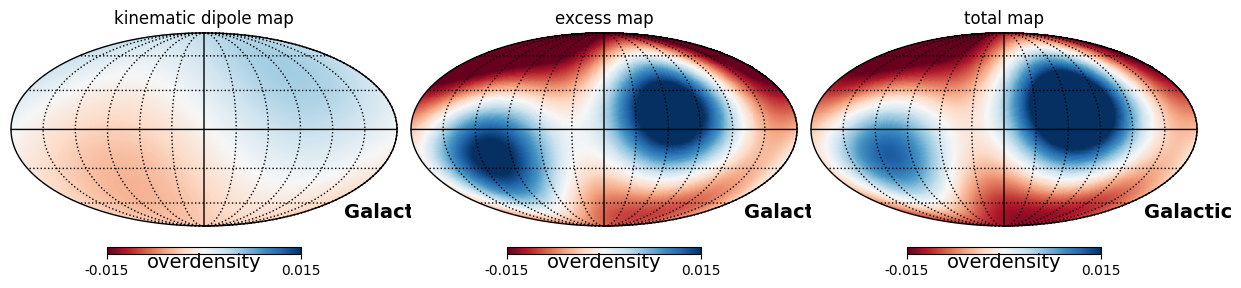

In [13]:
# plot: since there is no shot noise or selection effects, the total map == the full overdensity map
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], unit='overdensity', badcolor='w', cmap='RdBu', min=-.015, max=.015)
hp.mollview(input_kin_dipmap, title='kinematic dipole map', sub=(1,3,1), **kwargs)
hp.mollview(excess_map, title='excess map', sub=(1,3,2), **kwargs)
hp.mollview(total_map, title='total map', sub=(1,3,3), **kwargs)
hp.graticule()

In [14]:
# get the kinematic dipole
kin_dipole_comps = hp.fit_dipole(input_kin_dipmap)[1]
print(f"kinematic dipole = {kin_dipole_comps}; amplitude = {np.linalg.norm(kin_dipole_comps):.5f}")
# and the total dipole: this is the sum of the kinematic dipole and the excess power dipole
total_dipole_comps = hp.fit_dipole(odmap)[1]
print(f"total dipole = {total_dipole_comps}; amplitude = {np.linalg.norm(total_dipole_comps):.5f}")

kinematic dipole = [-0.00504284  0.00109153 -0.00064682]; amplitude = 0.00520
total dipole = [-0.00244054 -0.00097882 -0.00603717]; amplitude = 0.00658


#### free dipole excess model

In [21]:
nmocks = 500
ngens = 10
qs, res = get_abc_results_free_dipole_excess(os.path.join(case_dir,
                                    f'free_dipole_excess_nside{nside}_{nmocks}mocks_{ngens}iters_no-SN_ellmax-2', 'results.npy'), plot=False)

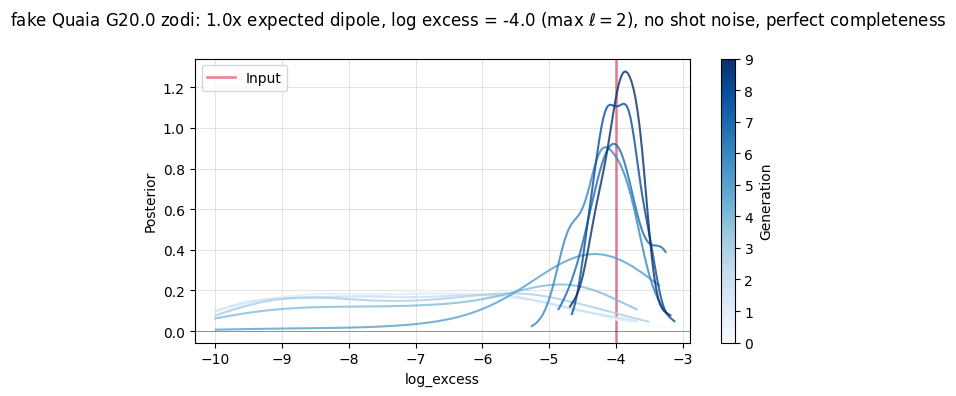

In [29]:
fig, ax = plt.subplots(figsize=(7,4), tight_layout=True)
history = res['history']
norm = mpl.colors.Normalize(vmin=0, vmax=history.max_t)
smap = mpl.cm.ScalarMappable(norm=norm, cmap='Blues')

ax.axvline(float(log_excess), c='crimson', alpha=0.5, lw=2, label='Input')
for i in range(history.max_t + 1):
    # alpha = (i + 1)**3 / (history.max_t + 1)**3
    pyabc.visualization.plot_kde_1d_highlevel(history, 'log_excess', t=i, ax=ax, color=smap.to_rgba(i), alpha=0.8)
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel('log_excess')
ax.axhline(0., c='k', alpha=0.5, lw=0.5)
fig.colorbar(smap, ax=ax, label='Generation')
fig.suptitle(label)
ax.legend()

### with selection function: comparing base rates

In [37]:
base_rates = [50., 60., 70., 80.]
nmocks = 500
ngens = 6
ell_max = 2

#### default acceptance threshold scheme (`QuantileEpsilon` with $\alpha = 0.5$)

Text(0.5, 0.98, 'log excess power posteriors, Quaia G20.0-like, excess power up to $\\ell=$2:\n                 6 generations, 500 mocks per generation:\n                 acceptance threshold scheme = QuantileEpsilon(alpha=0.5)')

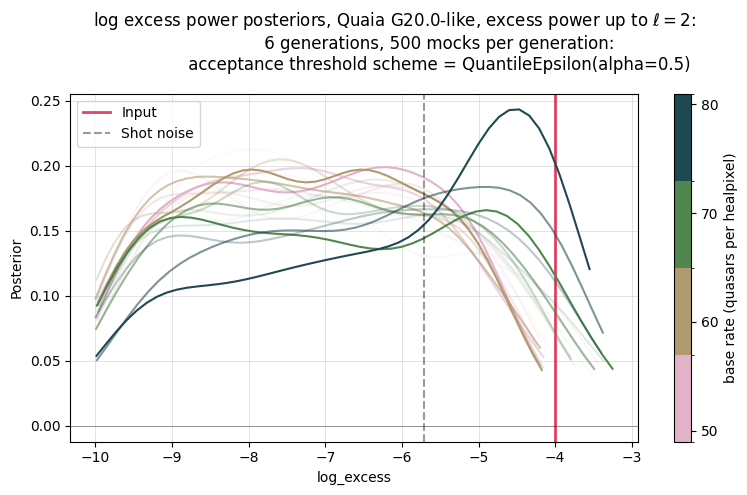

In [96]:
fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)
colors = sns.cubehelix_palette(len(base_rates), rot=-1.1, light=0.7, gamma=0.75)
bnorm = mpl.colors.BoundaryNorm(np.linspace(min(base_rates) - 1, max(base_rates) + 1, len(base_rates) + 1),
                                len(base_rates))
smap = mpl.cm.ScalarMappable(norm=bnorm, cmap=mpl.colors.ListedColormap(colors))

ax.axvline(float(log_excess), c='crimson', alpha=0.8, lw=2, label='Input')

for j, base_rate in enumerate(base_rates):
    case_dir = os.path.join(resdir, f'ABC/fake_data',
                            f'{sample_name}_base-rate-{base_rate:.4f}_dipamp-{rel_input_dipamp:.1f}x_excess-{log_excess}_ellmax-2')
    db_path = os.path.join(tempfile.gettempdir(), case_dir,
                                        f'dipole_excess_nside{nside}_{nmocks}mocks_{ngens}iters_ellmax-{ell_max}', f'history.db')
    history = pyabc.History("sqlite:///" + db_path)
                                                                     
    for i in range(history.max_t + 1):
        alpha = (i + 1)**3 / (history.max_t + 1)**3
        pyabc.visualization.plot_kde_1d_highlevel(history, 'log_excess', t=i, ax=ax, color=colors[j], alpha=alpha)
        
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel('log_excess')
ax.axhline(0., c='k', alpha=0.5, lw=0.5)
fig.colorbar(smap, ax=ax, label='base rate (quasars per healpixel)', ticks=base_rates)
ax.axvline(np.log10(1 / Nsources_quaia), c='k', alpha=0.4, ls='--', label='Shot noise')
ax.legend()
fig.suptitle(f'log excess power posteriors, Quaia G20.0-like, excess power up to 'r'$\ell=$'f'{ell_max}:\n \
                {ngens} generations, {nmocks} mocks per generation:\n \
                acceptance threshold scheme = QuantileEpsilon(alpha=0.5)')

#### `QuantileEpsilon` with $\alpha = 0.2$

Text(0.5, 0.98, 'log excess power posteriors, Quaia G20.0-like, excess power up to $\\ell=$2:\n                 6 generations, 500 mocks per generation:\n                 acceptance threshold scheme = QuantileEpsilon(alpha=0.2)')

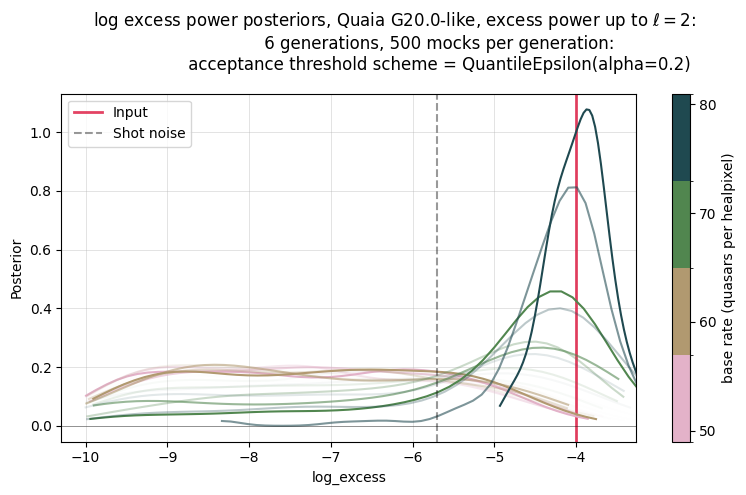

In [97]:
fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)
# colors = sns.husl_palette(len(base_rates))
colors = sns.cubehelix_palette(len(base_rates), rot=-1.1, light=0.7, gamma=0.75)
# colors = sns.color_palette('crest', len(base_rates))
bnorm = mpl.colors.BoundaryNorm(np.linspace(min(base_rates) - 1, max(base_rates) + 1, len(base_rates) + 1),
                                len(base_rates))
smap = mpl.cm.ScalarMappable(norm=bnorm, cmap=mpl.colors.ListedColormap(colors))

ax.axvline(float(log_excess), c='crimson', alpha=0.8, lw=2, label='Input')

for j, base_rate in enumerate(base_rates):
    case_dir = os.path.join(resdir, f'ABC/fake_data',
                            f'{sample_name}_base-rate-{base_rate:.4f}_dipamp-{rel_input_dipamp:.1f}x_excess-{log_excess}_ellmax-2')
    db_path = os.path.join(tempfile.gettempdir(), case_dir,
                                        f'dipole_excess_nside{nside}_{nmocks}mocks_{ngens}iters_ellmax-{ell_max}',
                                           'QuantileEpsilon_alpha-0.2', f'history.db')
    history = pyabc.History("sqlite:///" + db_path)
                                                                     
    for i in range(history.max_t + 1):
        alpha = (i + 1)**3 / (history.max_t + 1)**3
        pyabc.visualization.plot_kde_1d_highlevel(history, 'log_excess', t=i, ax=ax, color=colors[j], alpha=alpha)
        
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel('log_excess')
ax.axhline(0., c='k', alpha=0.5, lw=0.5)
fig.colorbar(smap, ax=ax, label='base rate (quasars per healpixel)', ticks=base_rates)
ax.axvline(np.log10(1 / Nsources_quaia), c='k', alpha=0.4, ls='--', label='Shot noise')
ax.legend()
fig.suptitle(f'log excess power posteriors, Quaia G20.0-like, excess power up to 'r'$\ell=$'f'{ell_max}:\n \
                {ngens} generations, {nmocks} mocks per generation:\n \
                acceptance threshold scheme = QuantileEpsilon(alpha=0.2)')

So with ~twice the real Quaia base rate we start to converge towards the input excess power after 6 generations with 500 accepted mocks.
But I wouldn't be surprised if the lower base rate cases also started to converge correctly, just after more generations.